# Fitting various models to the data

In [1]:
import numpy as np
import pymc as pm
import scipy.stats as stats

import itertools

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import bokeh.io
import bokeh.mpl
import bokeh.plotting
bokeh.io.output_notebook()

from IPython.core.pylabtools import figsize
from IPython import display
from getProcessed import getProcessed

titrD2 = getProcessed('titrationD2')
titrD4 = getProcessed('titrationD4')
timecourse = getProcessed('finalRun')



Couldn't import dot_parser, loading of dot files will not be possible.


Loading BokehJS ...

# First, we try an out of the box Gaussian mixture model

/usr/local/lib/python2.7/site-packages/matplotlib/axes/_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)
/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


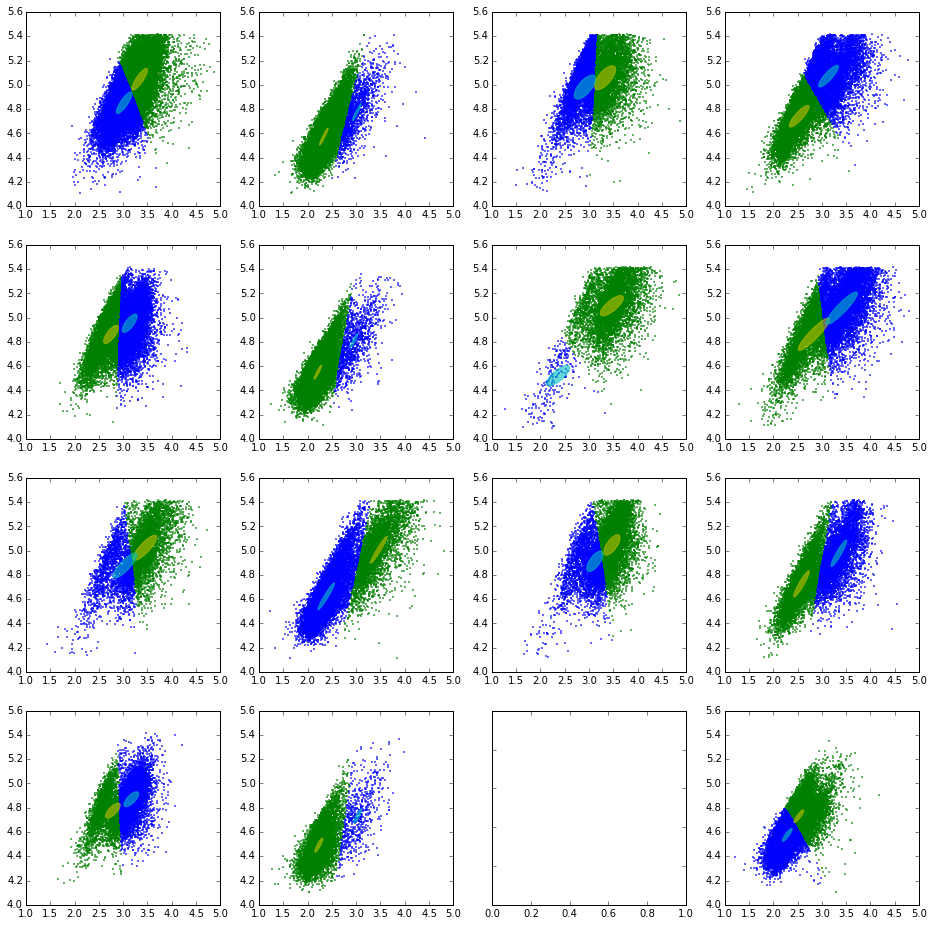

In [2]:
from sklearn import mixture
covariance_type='tied'

from fitGMMModel import plotModel, plotFreqs
figsize(16, 16)

#Try using a Gaussian mixture model
models = [ mixture.GMM( n_components=2, covariance_type=covariance_type, n_iter=800, n_init=20) for entry in timecourse.gated]
toFit = [ np.log10(entry.data[['M Cherry-A', 'SSC-A']]).dropna().as_matrix() for entry in timecourse.gated ]

toFitIndices = [np.random.choice(range(entry.shape[0]), size=(2000,1)) for entry in toFit]
toFitSamples = [ toFit[index][toFitIndices[index], :].squeeze() for index in range(len(toFit)) ]

plt.subplots(4, 4, sharex='col', sharey='row')

for index in range(len( timecourse.gated)):
    models[index].fit( toFitSamples[index] )

    plotModel( models[index], toFit[index], plotnum=index, covariance_type=covariance_type)
    plt.autoscale(tight=True)
    plt.xlim([1,5])
    plt.ylim([4, 5.6])
    #print index
    

plt.show()

The out of the box solver usually does ok in capturing the behaviors that we can see by eye. However, it would be nice to have better control over the covariance matrices that we are fitting. In order to do this, I tried a more curated approach to the problem.

# MCMC approach
We can make use of some of our previous controls to fit the correlation matrices for the clustering

In [3]:
import pymc as pm
import scipy.stats as stats

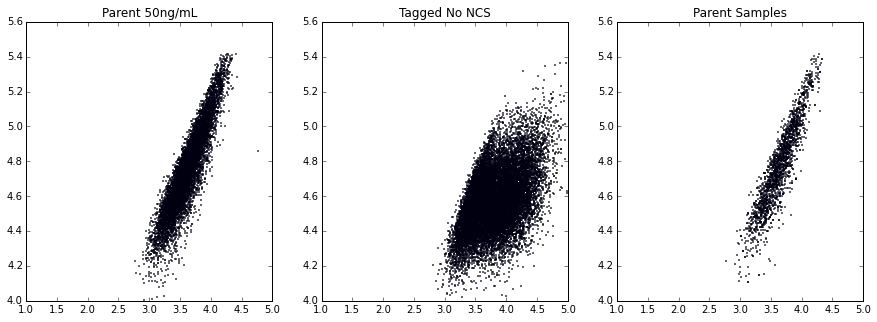

In [4]:
noTag = np.log10( titrD4.gated[2].data[['M Cherry-A', 'SSC-A']]).dropna().as_matrix()
negTag = np.log10( titrD4.gated[-1].data[['M Cherry-A', 'SSC-A']]).dropna().as_matrix()

# take a set of samples to train on from the parental dataset.
ind = np.random.choice(range(noTag.shape[0]), size=(2000,1))
noTagSamples = noTag[ind,:].squeeze()

figsize(15,5)
plt.subplot(1,3,1)
plt.scatter(noTag[:,0], noTag[:,1], 0.5);
plt.xlim([1,5])
plt.ylim([4, 5.6]);
plt.title('Parent 50ng/mL');

plt.subplot(1,3,2)
plt.scatter(negTag[:,0], negTag[:,1], 0.5);
plt.xlim([1,5])
plt.ylim([4, 5.6]);
plt.title( 'Tagged No NCS');

plt.subplot(1,3,3)
plt.scatter(noTagSamples[:,0], noTagSamples[:,1], 0.5);
plt.xlim([1,5])
plt.ylim([4, 5.6]);
plt.title('Parent Samples');




The plot was shifted because of the difference in PMT gain in the mCh channel. Fit a multivariate Gaussian to find the cross-correlation structure 

Examining the prior distributions and the evolution of the distributions over time shows the sureness of the fit and whether the burn time was sufficient

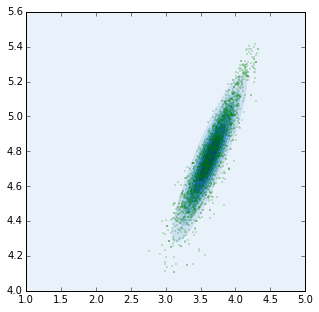

In [5]:
controlFit = mixture.GMM( n_components=1, covariance_type='full')
controlFit.fit(noTag)

ctlCovars = controlFit.covars_[0]
ctlMean = controlFit.means_[0]

ctlTaus = np.linalg.inv( ctlCovars)


#generate the plot
xs = np.linspace(1, 5, 200)
ys = np.linspace(4, 5.6, 200)

X, Y = np.meshgrid(xs, ys)
position = np.dstack((X, Y))

full_posterior = stats.multivariate_normal(ctlMean, ctlCovars)

figsize(5,5)
plt.contourf( X, Y, full_posterior.pdf(position), cmap="Blues")
plt.scatter(noTagSamples[:,0], noTagSamples[:,1], 0.3, color='g', alpha=0.4);
plt.xlim([1,5])
plt.ylim([4, 5.6]);


### Beautiful.
Does expressing everything in terms of the eigenvectors of this covariance help anything? Alternatively, can we just tdo the fits with fixed covarance?

In [6]:
from sklearn.mixture import GMM

toFit = [ np.log10(entry.data[['M Cherry-A', 'SSC-A']]).dropna().as_matrix() for entry in timecourse.gated ]

toFitIndices = [np.random.choice(range(entry.shape[0]), size=(2000,1)) for entry in toFit]
toFitSamples = [ toFit[index][toFitIndices[index], :].squeeze() for index in range(len(toFit)) ]

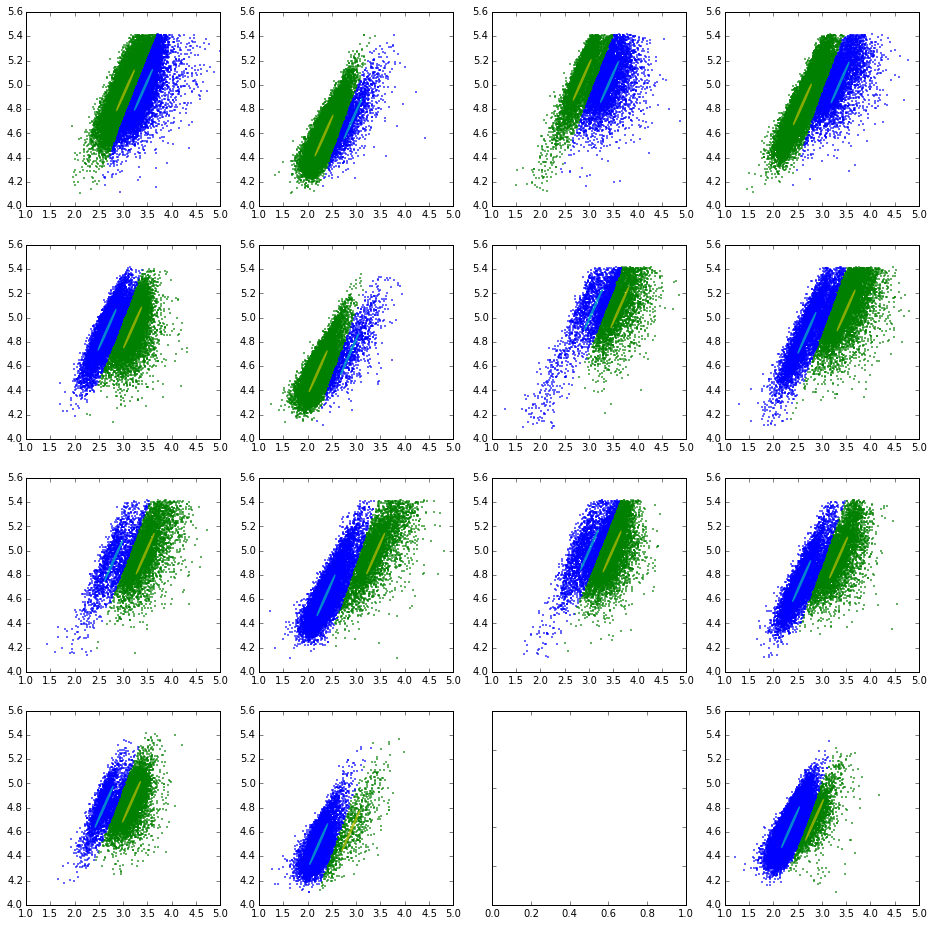

In [7]:
figsize(16, 16)

covariance_type = 'tied'

skinnyModels = [ GMM( n_components=2, covariance_type=covariance_type, n_iter=500, n_init=50, init_params='wm', params='wm') for entry in timecourse.gated]
for entry in skinnyModels:
    entry.covars_ = ctlCovars


plt.subplots(4, 4, sharex='col', sharey='row')

for index in range(len( timecourse.gated)):
    skinnyModels[index].fit( toFitSamples[index] )

    plotModel( skinnyModels[index], toFit[index], plotnum=index, covariance_type=covariance_type)
    plt.autoscale(tight=True)
    plt.xlim([1,5])
    plt.ylim([4, 5.6])
    #print index
    

plt.show()

This wierd, quirky method seems to be pretty good: one fat cluster, one skinny cluster. It has the opposite problem from two skinny clusters, namely, mislabelling offs as ons.  

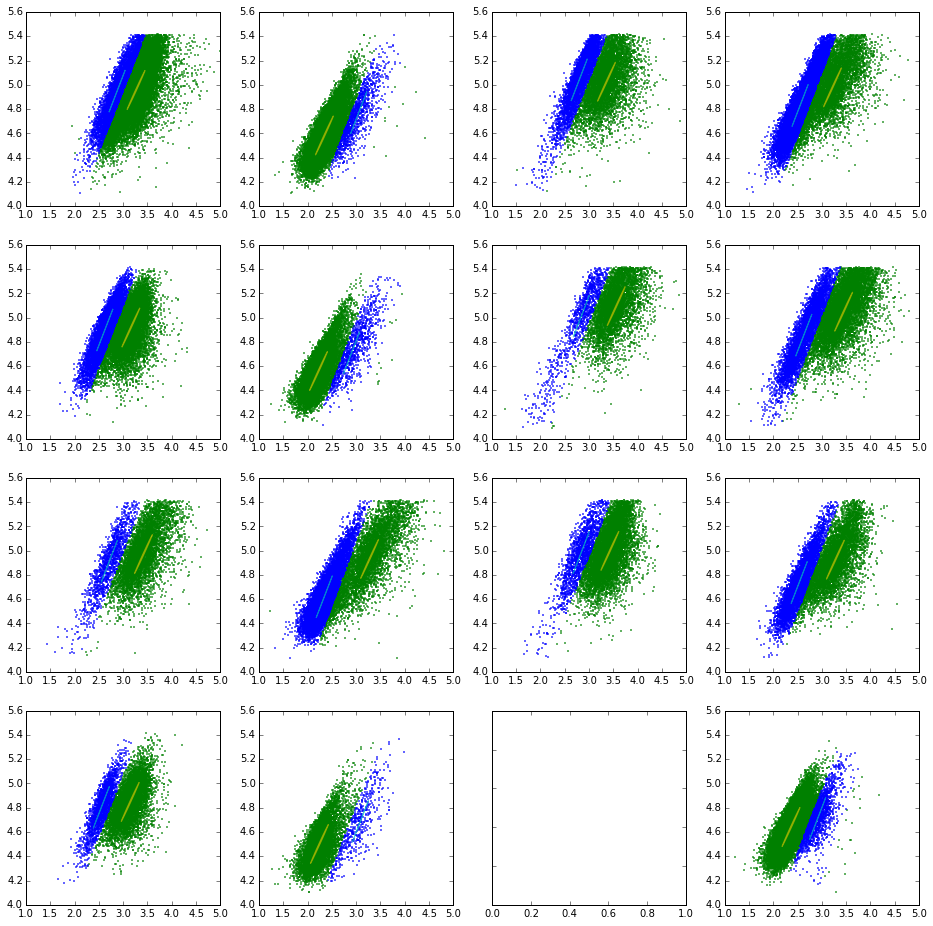

In [8]:
figsize(16, 16)

#try making it wider
eig_b = np.linalg.eig(ctlCovars)
D = np.diag( eig_b[0] * [1, 2])
P = eig_b[1]
newCov = np.dot(P, np.dot( D, np.linalg.inv( P) ) )

covariance_type = 'full'
fullCovars = np.dstack( [ctlCovars, newCov])

fatModels = [ GMM( n_components=2, covariance_type=covariance_type, n_iter=500, n_init=50, init_params='wm', params='wm') for entry in timecourse.gated]
for entry in fatModels:
    entry.covars_ = fullCovars

plt.subplots(4, 4, sharex='col', sharey='row')

for index in range(len( timecourse.gated)):
    fatModels[index].fit( toFitSamples[index] )

    plotModel( fatModels[index], toFit[index], plotnum=index, covariance_type=covariance_type)
    plt.autoscale(tight=True)
    plt.xlim([1,5])
    plt.ylim([4, 5.6])
    #print index

In [9]:
[entry.ID for entry in timecourse.gated]

['d0_neg_001.fcs',
 'd2_+_002.fcs',
 'd2_neg_001.fcs',
 'd4_++_004.fcs',
 'd4_+-_003.fcs',
 'd4_-+_002.fcs',
 'd4_--_001.fcs',
 'd6_+++_008.fcs',
 'd6_++-_004.fcs',
 'd6_+-+_006.fcs',
 'd6_+--_003.fcs',
 'd6_-++_007.fcs',
 'd6_-+-_002.fcs',
 'd6_--+_005.fcs',
 'd6_---_001.fcs']

In [10]:
test

NameError: name 'test' is not defined

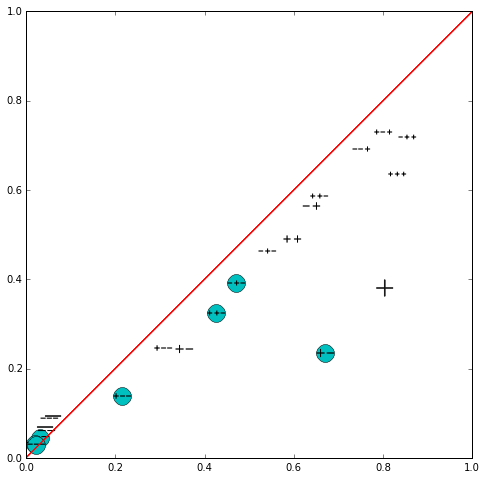

In [11]:
import fitGMMModel
reload(fitGMMModel)
from fitGMMModel import plotFreqs, plotTCourse

dayDict = { 0:[0], 
           2:[1, 2],
          4:[3, 4, 5, 6,],
          6: [7, 8, 9, 10, 11, 12, 13, 14]}
irDict = { 0:'-', 
           1:'+', 2:'-',
          3:'++', 4:'+-', 5:'-+', 6:'--',
          7:'+++', 8:"++-", 9:'+-+', 10:'+--', 11:'-++', 12:'-+-', 13:'--+', 14:'---'}

#get the percentage in the on population
fatOn = [ entry.weights_[ np.argmax( entry.means_[:,0])] for entry in fatModels]
skinnyOn = [ entry.weights_[ np.argmax( entry.means_[:,0])] for entry in skinnyModels]
      
figsize(8, 8)
#plt.subplots(4, 1, sharex='col', sharey='row')
plotFreqs(fatOn, skinnyOn, dayDict, irDict )
    

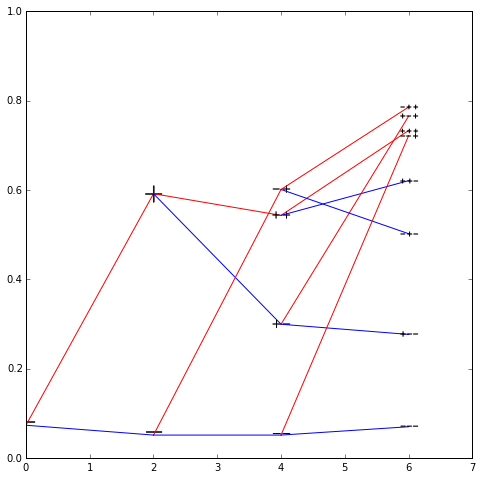

In [15]:
import fitGMMModel
reload(fitGMMModel)
from fitGMMModel import plotFreqs, plotTCourse

irDictInv = {
           '+':1, '-':2,
          '++':3, '+-':4, '-+':5, '--':6,
          '+++':7, '++-':8, '+-+':9, '+--':10, '-++':11, '-+-':12, '--+':13, '---':14}

figsize(8, 8)
#plt.subplots(4, 1, sharex='col', sharey='row')
plotTCourse(fatOn, skinnyOn, dayDict, irDict, irDictInv)

In [13]:
import fitGMMModel
reload(fitGMMModel)
from fitGMMModel import plotFreqs, plotTCourse, plotDists




In [ ]:
# New mixture model for fitting the experimental data.
# Once again, the GMM doesn't work because there is no control over the structure of the covariance matrix

def makeModel(data, covType='fixed'):
    # Assignment to a cloud
    p = pm.Uniform("p", 0, 1) #prior

    assignment = pm.Categorical("assignment", [p, 1 - p], size=data.shape[0])

    if covType == 'fixed':
        fitTau = ctlTaus
        #mean prior
        center_0 = pm.MvNormal('center_0', np.array([2.5, 5]), fitTau )
        center_1 = pm.MvNormal('center_1', np.array([3, 5]), fitTau ) 

        
        # while the most one dimensional distributions are comfortable generating multiple samples,
        # the MvNormal is not. As a result, we must make a multi-MvNormal variable
        @pm.stochastic(observed=True)
        def empirical(value=data, center_0=center_0, center_1=center_1, tau=fitTau, assignment=assignment):
            # assume that the data is IID.
            running = 0
            # do each of the the subpopulations independently
            pop_0 = data[assignment == 0]
            pop_1 = data[assignment == 1]


            prob_0 = pm.mv_normal_like(pop_0, center_0, tau)
            prob_1 = pm.mv_normal_like(pop_1, center_1, tau)
            return prob_0 + prob_1
        
        
    elif covType == 'diag':
        #diagonally shaped covariance matrix.

        # This keeps the distribution the same shape, while changing size
        
        a0 = pm.Exponential('a0', 2)
        a1 = pm.Exponential('a1', 2)
        
        @pm.deterministic(name='fitTau_0')
        def fitTau_0(a=a0):
            eigs = np.linalg.eig(ctlCovars)
            D = np.diag( eigs[0] * [1, a])
            P = eigs[1]

            newCovs = np.dot(P, np.dot( D, np.linalg.inv( P) ) )
            
            return np.linalg.inv(newCovs)
        
        @pm.deterministic(name='fitTau_1')
        def fitTau_1(a=a1):
            eigs = np.linalg.eig(ctlCovars)
            D = np.diag( eigs[0] * [1, a])
            P = eigs[1]
            newCovs = np.dot(P, np.dot( D, np.linalg.inv( P) ) )
            
            return np.linalg.inv(newCovs)
        
        #mean prior
        center_0 = pm.MvNormal('center_0', np.array([2.5, 5]), fitTau_0 )
        center_1 = pm.MvNormal('center_1', np.array([3, 5]), fitTau_1 ) 
        
        # while the most one dimensional distributions are comfortable generating multiple samples,
        # the MvNormal is not. As a result, we must make a multi-MvNormal variable
        @pm.stochastic(observed=True)
        def empirical(value=data, center_0=center_0, center_1=center_1, tau0=fitTau_0, tau1=fitTau_1, assignment=assignment):
            # assume that the data is IID.
            running = 0
            # do each of the the subpopulations independently
            pop_0 = data[assignment == 0]
            pop_1 = data[assignment == 1]


            prob_0 = pm.mv_normal_like(pop_0, center_0, tau0)
            prob_1 = pm.mv_normal_like(pop_1, center_1, tau1)
            return prob_0 + prob_1
        
    else:
        nCTLs = noTag.shape[0]
        fitTau = pm.Wishart('fitTau', nCTLs,  tau_post_mean)
    
        #mean prior
        center_0 = pm.MvNormal('center_0', np.array([2.5, 4.8]), fitTau )
        center_1 = pm.MvNormal('center_1', np.array([3, 4.8]), fitTau ) 


        # while the most one dimensional distributions are comfortable generating multiple samples,
        # the MvNormal is not. As a result, we must make a multi-MvNormal variable
        @pm.stochastic(observed=True)
        def empirical(value=data, center_0=center_0, center_1=center_1, tau=fitTau, assignment=assignment):
            # assume that the data is IID.
            running = 0
            # do each of the the subpopulations independently
            pop_0 = data[assignment == 0]
            pop_1 = data[assignment == 1]


            prob_0 = pm.mv_normal_like(pop_0, center_0, tau)
            prob_1 = pm.mv_normal_like(pop_1, center_1, tau)
            return prob_0 + prob_1

    if covType == 'diag':
        expModel = pm.Model( [p, assignment, a0, a1, fitTau_0, fitTau_1, center_0, center_1, empirical])
    else:
        expModel = pm.Model( [p, assignment, fitTau, center_0, center_1, empirical])
        
    return expModel


# an old solution
#@pm.deterministic
#def centers( assignment=assignment, center_0=center_0, center_1=center_1):
#    out = np.zeros(( len(data),  2) ) #initialize output
#    out[ assignment == 0, :] = center_0 
#    out[ assignment == 1,:] = center_1
#    return out

#test = makeModel( toFitSamples[13], covType='diag')
#testMCMC = pm.MCMC(test)

#nSamp = 20000
#burn= 3000
#times = np.array( range(nSamp-burn) )

#testMCMC.sample(nSamp, burn)




In [ ]:
figsize(10,10)

currModel = testMCMC
currSamples = toFitSamples[13]

a = currModel.trace('assignment') 
assOut = a[-1]


plt.scatter( currSamples[assOut==0,0],  currSamples[assOut==0,1], 0.5, color='b');
plt.scatter( currSamples[assOut==1,0],  currSamples[assOut==1,1], 0.5, color='g');

plt.xlim([1,5])
plt.ylim([4, 5.6])

In [ ]:
currSamples[ assOut == 1,1 ]

In [ ]:
# take samples of the distributions
toFitIndices = [np.random.choice(range(entry.shape[0]), size=(2000,1)) for entry in toFit]
toFitSamples = [ toFit[index][toFitIndices[index], :].squeeze() for index in range(len(toFit)) ]

# make the models
fullModels = [ makeModel(entry, covType='fixed') for entry in toFitSamples]
fullMCMCs = [ pm.MCMC(entry) for entry in fullModels ]

#
graph = pm.graph.dag( fullModels[0])
display.Image(graph.create_png())


# fit the models
nSamp = 5000
burn= 500
times = np.array( range(nSamp-burn) )

i = 0
for entry in fullMCMCs:
    print i
    entry.sample(nSamp, burn)
    
    i += 1


In [ ]:
# plot the full fits.
figsize(16, 16)
plt.subplots(4, 4, sharex='col', sharey='row')

for index in range(len(fullMCMCs)):
    currModel = fullMCMCs[index]
    currSamples = toFitSamples[index]
    
    a = currModel.trace('assignment') 
    assOut = a[-1]
    
    plt.subplot(4, 4, index)

    plt.scatter( currSamples[assOut==0,0],  currSamples[assOut==0,1], 0.5, color='b');
    plt.scatter( currSamples[assOut==1,0],  currSamples[assOut==1,1], 0.5, color='g');
    
    plt.xlim([1,5])
    plt.ylim([4, 5.6])
    
    

In [ ]:
figsize(16, 16)
plt.subplots(4, 4, sharex='col', sharey='row')

for index in range(len(fullMCMCs)):
    currModel = fullMCMCs[index]
    currSamples = toFitSamples[index]
    
    plt.subplot(4, 4, index)
    a = fullMCMCs[index].trace('a0')
    plt.plot(a[:]);

## Notes about various fit types:
### Naive Gaussian mixture model:
Fits ok. The real problems come in when the covariance matrices get too wonky, giving more of a top-bottom profile.
### GMM with fixed variances:
Quite nice. The only real problem seems to be when the width of the distribution is too large. Especially for the off distribution.
### GMM using prior from the control:
Pretty poor fit. The top-bottom issue comes back, and appears worse than the naive model, probably because the training set is smaller and there is only one run, which converges slowly. 
### GMM adjusting just the width

In [ ]:
figsize(16, 16)

for index in [13]:
    currModel = fullMCMCs[index]
    currSamples = toFitSamples[index]
    
    a = currModel.trace('assignment') 
    assOut = a[-1]
    
    #plt.subplot(4, 4, index)
    plt.scatter( currSamples[assOut==0,0],  currSamples[assOut==0,1], 0.5, color='b');
    plt.scatter( currSamples[assOut==1,0],  currSamples[assOut==1,1], 0.5, color='g');
    
    plt.xlim([1,5])
    plt.ylim([4, 5.6])

In [ ]:
a = ctlTaus
b = ctlCovars
print a

In [ ]:
eig_a = np.linalg.eig(a)


In [ ]:
print eig_b

In [ ]:
a = 2

eig_b = np.linalg.eig(ctlCovars)
D = np.diag( eig_b[0] * [1, 2])
P = eig_b[1]
newCov = np.dot(P, np.dot( D, np.linalg.inv( P) ) )


print P

eVec1 = 1 * P[:,0]
eVec2 = 1* P[:,1]


P = np.dstack([eVec1, eVec2]).squeeze()

print P





#newCov = np.linalg.inv( newTaus)

#print newTaus

#taus = np.power(tau_post_mean, 11)
#newCov = np.linalg.inv(taus)

#print newCov

X, Y = np.meshgrid(xs, ys)
position = np.dstack((X, Y))

full_posterior = stats.multivariate_normal(ctlMean, ctlCovars)
new_posterior = stats.multivariate_normal( ctlMean, newCov)

figsize(5,5)
plt.contourf( X, Y, new_posterior.pdf(position), cmap="Greens")
#plt.contourf( X, Y, full_posterior.pdf(position), cmap="Blues", alpha=0.5)
plt.xlim([1,5])
plt.ylim([4, 5.6]);

In [ ]:
eVec1 = P[:,0]
eVec2 = P[:,1]

In [ ]:
eVec1

In [ ]:
np.dstack( [eVec1, eVec2])

In [ ]:
P

In [ ]:
# trying out more scikit-learn functions. I got tired of waiting for the Gibbs sampler
adjacency = ctlTaus

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

from scipy.spatial.distance import pdist


n_clusters = 2

test_kernel =  pdist(toFitSamples[13], 'euclidean')

print test_kernel.shape

test = AgglomerativeClustering(n_clusters=n_clusters, affinity=test_kernel, linkage="complete" )
test.fit( toFitSamples[13])



In [ ]:
figsize(10, 10)
plt.scatter(toFitSamples[13][:, 0], toFitSamples[13][:, 1], c=test.labels_, cmap='PiYG')

In [ ]:
a = toFitSamples[13]
a[0]
a[1]

In [ ]:
a.shape

In [ ]:
b = linear_kernel(a)
b.shape

In [ ]:
ctlTaus

In [ ]:
a = fullMCMCs[index].trace('fitTau_0')
a[-1,:,:]

In [ ]:
# old stuff -- this only works sometimes... why??

In [ ]:
# the model

#priors
# Wishart prior
tauGuess = np.eye(2)
taus = pm.Wishart('taus', 2, tauGuess )

centerGuess = np.array([3.7, 4.7])
center = pm.MvNormal('center', centerGuess, taus)

#distribuion
empirical = pm.MvNormal('empirical', center, taus, value=noTagSamples, observed=True)

model = pm.Model([empirical, taus, center])

graph = pm.graph.dag( model)
display.Image(graph.create_png())

In [ ]:
mcmc = pm.MCMC(model)

#M = pm.MAP(model)
#M.fit()

nSamp = 12000
burn= 2000
times = np.array( range(nSamp-burn) )
samples = mcmc.sample(nSamp, burn)

In [ ]:
figsize(10,5);


cenTrace = mcmc.trace('center')
plt.subplot(1,2,1)
plt.hist( cenTrace[:], bins=20 );

tauTrace = mcmc.trace('taus')
plt.subplot(1,2,2)
plt.hist(tauTrace[:,0,0], bins=10);
plt.hist(tauTrace[:,1,1], bins=10);
plt.hist(tauTrace[:,0,1], bins=10, color='r', alpha=0.8);
plt.hist(tauTrace[:,1,0], bins=10, color='c', alpha=0.6);



In [ ]:
figsize(20,5);
plt.subplot(1,2,1)
plt.plot( times, cenTrace[:,0])
plt.plot( times, cenTrace[:,1])


plt.subplot(1,2,2)
plt.plot( times, tauTrace[:,0,0])
plt.plot( times, tauTrace[:,1,1])
plt.plot( times, tauTrace[:,0,1], color='r', alpha=0.8)
plt.plot( times, tauTrace[:,1,0], color='c', alpha=0.6)


#Approximate by the posterior mean. This is itself an approximation to the MAP distribution
center_post_mean = cenTrace[:].mean(axis=0)
tau_post_mean = tauTrace[:].mean(axis=0)

cov_post_mean = np.linalg.inv(tau_post_mean)